In [ ]:
#|default_exp callback.gradaccum
#|default_cls_lvl 2

In [ ]:
#|exporti
# Contains code from:
# fastai - Apache License 2.0 - Copyright (c) 2023 fast.ai

# Gradient Accumulation
> Accumulate multiple mini-batches into one batch

Gradient accumulation allows training on batch sizes which are too large to fit into memory by splitting each batch into mini-batches and skipping the optimizer step until gradients have been accumulated from all mini-batches.

fastai gradient accumulation works by treating each dataloader batch as a mini-batch, and then accumulating the mini-batches across multiple forward and backward steps into one larger batch.

## Differences from fastai

By default, `GradientAccumulation` and `GradientAccumulationWarmup` record and log accumulated batches instead of micro-batches. This effects training losses and Weights and Biases training steps.

Recorded and logged training losses are the accumulated loss used for the optimization step, not the last micro-batch loss as fastai records. Weights and Biases training steps will be reduced by ratio of micro-batches to accumulated batches, while TensorBoard training steps will be uneffected. 

To revert to fastai behavor of recording micro-batches, set `log_accum_batch=False`.

In [ ]:
#|export
from __future__ import annotations

import math

from fastai.callback.core import Callback, CancelBatchException
from fastai.callback.schedule import SchedCos, _Annealer

from fastxtend.callback.amp import MixedPrecision
from fastxtend.callback.utils import *
from fastxtend.imports import *

In [ ]:
#|hide
from fastxtend.test_utils import *

In [ ]:
#|exporti
_grad_loggers = available_loggers.copy()
_grad_loggers['recorder'] = True

In [ ]:
#|export
class GradientAccumulation(Callback):
    "Accumulate gradients before updating weights"
    order,run_valid = MixedPrecision.order-4,False
    def __init__(self,
        accum_bs:int|None, # Accumulation batch size. Defaults to `n_acc` if not set
        n_acc:int=32, # Default `accum_bs` value. Used for compatability with fastai
        log_accum_batch:bool=True, # Log each accumulated batch (True) or micro batch (False). False is default fastai behavior
    ):
        accum_bs = n_acc if accum_bs is None else accum_bs
        store_attr(but='n_acc')

    def before_fit(self):
        self.count = 0
        self._loggers = []
        self.accum_loss = None
        self.wandb_epoch = False
        if self.log_accum_batch:
            for logger, available in _grad_loggers.items():
                if available and hasattr(self.learn, logger):
                    self._loggers.append(getattr(self.learn, logger))
                    if logger=='wandb':
                        self.wandb_epoch = True

    def after_loss(self):
        bs = find_bs(self.learn.yb)
        self.count += bs
        self.accum_steps = self.accum_bs // bs
        self.learn.loss_grad /= self.accum_steps
        if self.accum_loss is None:
            self.accum_loss = torch.zeros_like(self.learn.loss)

    def before_step(self):
        "Skip weight update if we have not seen enough items"
        if self.count < self.accum_bs:
            if self.log_accum_batch:
                self.accum_loss += self.learn.loss.detach() / self.accum_steps
                self._run_loggers(False)
            # skip step/zero_grad
            raise CancelBatchException()
        else:
            self.count = 0
            if self.log_accum_batch:
                self.learn.loss = self.accum_loss + self.learn.loss.detach() / self.accum_steps
                self.accum_loss = torch.zeros_like(self.learn.loss)
                self._run_loggers(True)

    def after_epoch(self):
        "Turn on Recorder & Loggers to log final epoch metrics"
        if self.log_accum_batch:
            self._run_loggers(True)

    def _run_loggers(self, run_train):
        for l in self._loggers:
            l.run_train = run_train
        if self.wandb_epoch and not run_train:
            self.learn.wandb._wandb_epoch += 1/self.n_iter

In [ ]:
#|export
class GradientAccumulationSchedule(GradientAccumulation, CallbackScheduler):
    "Gradient accumulation with a schedulable batch size"
    def __init__(self,
        start_accum_bs:int, # Initial gradient accumulation batch size
        final_accum_bs:int, # Final gradient accumulation batch size
        start:Numeric=0, # Start batch size schedule in percent of training steps (float) or epochs (int, index 0)
        finish:Numeric=0.3, # Finish batch size schedule in percent of training steps (float) or epochs (int, index 0)
        schedule:Callable[..., _Annealer]=SchedCos, # Batch size schedule type
        log_accum_batch:bool=True, # Log each accumulated batch (True) or micro batch (False). False is default fastai behavior
        micro_batch_size:int|None=None # Manually set micro-batch size if using non-fastai or non-fastxtend dataloader
    ):
        GradientAccumulation.__init__(self, accum_bs=start_accum_bs, log_accum_batch=log_accum_batch)
        CallbackScheduler.__init__(self)
        store_attr(names='start_accum_bs,final_accum_bs,start,finish,schedule')
        self.micro_batch_size=micro_batch_size

    def before_fit(self):
        self._sched_accum_bs = self.accum_bs
        if self.micro_batch_size is None:
            self.micro_batch_size=self.dls.bs

        if self.micro_batch_size > self.accum_bs:
            raise ValueError(f"{self.accum_bs=} cannot be smaller then the dataloader batch size {self.micro_batch_size=}")

        super().setup_schedule(
            n_epoch=self.n_epoch,
            dls_len=len(self.dls.train),
            start_value=self.start_accum_bs,
            final_value=self.final_accum_bs,
            start=self.start,
            finish=self.finish,
            schedule=self.schedule,
            callback_name='Gradient Accumulation Schedule')
        super().before_fit()

    def before_batch(self):
        "Update gradient accumulation batch size per schedule"
        self._sched_accum_bs = super().schedule_step(self._sched_accum_bs, self.pct_train)
        # Only update accum_bs if we are at the beginning of a new macro-batch
        if self.count == 0:
            self.accum_bs = int(math.floor(self._sched_accum_bs / self.micro_batch_size) * self.micro_batch_size)

    def _run_loggers(self, run_train):
        super()._run_loggers(run_train)
        if run_train:
            self.learn._log_values(accumulation_batch_size=self.accum_bs)

## Tests -

In [ ]:
#|hide
#|cuda
import matplotlib.pyplot as plt

from fastcore.basics import num_cpus

from fastai.callback.training import GradientAccumulation as GradAccum
from fastai.data.external import URLs, untar_data
from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.transforms import GrandparentSplitter, get_image_files, parent_label, Normalize
from fastai.learner import Learner
from fastai.vision.augment import Resize
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock

from fastxtend.callback import channelslast
from fastxtend.callback.tracker import LastMetricCallback
from fastxtend.metrics import *
from fastxtend.optimizer.fused import adam
from fastxtend.vision.models.xresnet import xresnext34
from fastxtend.utils import free_gpu_memory

In [ ]:
#|hide
#|cuda
imagenette = untar_data(URLs.IMAGENETTE_160)

accuracy = []
for cb, name in zip([GradientAccumulation(128), GradAccum(128)], ['fastxtend', 'fastai']):
    print(name)
    with less_random():
        dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=Resize(128),
                        batch_tfms=[Normalize.from_stats(*imagenet_stats)])

        dls = dblock.dataloaders(imagenette, bs=32, num_workers=num_cpus())

        cbs = [] if cb is None else [cb]
        learn = Learner(dls, xresnext34(n_out=dls.c), opt_func=adam(foreach=True),
                        loss_func=nn.CrossEntropyLoss(label_smoothing=0.1),
                        metrics=Accuracy(), cbs=cbs+[LastMetricCallback()]).to_channelslast()

        learn.fit_one_cycle(5, 3e-3)
        accuracy.append(learn.lastmetric['accuracy'])

        free_gpu_memory(learn, dls)

test_close(accuracy[0], accuracy[1])

fastxtend


epoch,train_loss,valid_loss,accuracy,time
0,1.785653,1.651538,0.532229,00:12
1,1.442656,1.283555,0.676433,00:10
2,1.199092,1.113374,0.755669,00:10
3,1.041552,0.998629,0.800764,00:12
4,0.927283,0.976738,0.812229,00:11


fastai


epoch,train_loss,valid_loss,accuracy,time
0,1.619772,1.651538,0.532229,00:11
1,1.309767,1.283555,0.676433,00:11
2,1.116553,1.113374,0.755669,00:11
3,0.985003,0.998629,0.800764,00:11
4,0.899296,0.976738,0.812229,00:11


In [ ]:
#|hide
#|cuda
class GradAccumSchedTest(Callback):
    "Test EMACallback against timm's ModelEmaV2"
    order,run_valid = GradientAccumulationSchedule.order+1,False

    def before_fit(self):
        self.accum_bs, self.epochs = [], []

    def after_batch(self):
        self.accum_bs.append(self.learn.gradient_accumulation_schedule.accum_bs)

    def after_fit(self):
        plt.figure(figsize=(4,4))
        plt.plot(self.accum_bs)
        plt.xlabel('Micro-Batch Steps')
        plt.ylabel('Accumulated Batch Size')

epoch,train_loss,valid_loss,accuracy,time
0,1.652636,1.713672,0.495796,00:13
1,1.324317,1.343712,0.656815,00:11
2,1.105591,1.070178,0.778089,00:11
3,0.967111,0.954822,0.823185,00:11
4,0.881434,0.947054,0.823949,00:11


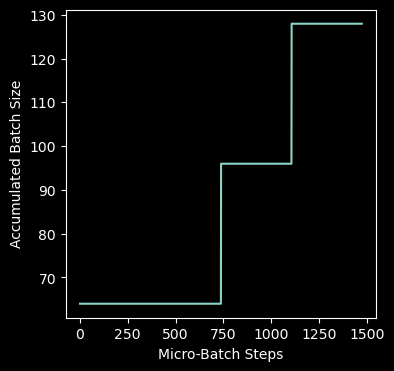

In [ ]:
#|hide
#|cuda
with less_random():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=GrandparentSplitter(valid_name='val'),
                    get_items=get_image_files, get_y=parent_label,
                    item_tfms=Resize(128),
                    batch_tfms=[Normalize.from_stats(*imagenet_stats)])

    dls = dblock.dataloaders(imagenette, bs=32, num_workers=num_cpus())

    cbs = [GradientAccumulationSchedule(64, 128, 0.25, 0.75)]
    learn = Learner(dls, xresnext34(n_out=dls.c), opt_func=adam(foreach=True),
                    loss_func=nn.CrossEntropyLoss(label_smoothing=0.1),
                    metrics=Accuracy(), cbs=cbs+[GradAccumSchedTest]).to_channelslast()

    learn.fit_one_cycle(5, 3e-3)